In [1]:
import sf_quant.data as sfd
import polars as pl
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

/home/jaic007/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-30 15:56:48,594	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# start = dt.date(1995, 6, 30)
start = dt.date(2022, 6, 30)
end = dt.date(2024, 12, 31)

benchmark = sfd.load_benchmark(
    start=start,
    end=end,
)

benchmark

date,barrid,weight
date,str,f64
2022-06-30,"""USA06Z1""",0.00001
2022-07-01,"""USA06Z1""",0.00001
2022-07-05,"""USA06Z1""",0.000011
2022-07-06,"""USA06Z1""",0.00001
2022-07-07,"""USA06Z1""",0.00001
…,…,…
2024-12-24,"""USBQOR1""",0.000058
2024-12-26,"""USBQOR1""",0.000061
2024-12-27,"""USBQOR1""",0.000058


In [3]:
columns = ["date", "barrid", "fwd_return"]
returns = sfd.load_assets(start=start, end=end, in_universe=True, columns=columns)

returns

date,barrid,fwd_return
date,str,f64
2022-06-30,"""USA06Z1""",2.8818
2022-07-01,"""USA06Z1""",5.3221
2022-07-05,"""USA06Z1""",-1.5957
2022-07-06,"""USA06Z1""",2.1622
2022-07-07,"""USA06Z1""",-8.4656
…,…,…
2024-12-24,"""USBQOR1""",4.293
2024-12-26,"""USBQOR1""",-5.108
2024-12-27,"""USBQOR1""",-4.2663


In [4]:
benchmark_returns = (
    benchmark.join(returns, on=["date", "barrid"], how="left")
    .with_columns(
        (pl.col("fwd_return") / 100)
    )
    .group_by("date")
    .agg(
        (pl.col("fwd_return") * pl.col("weight")).sum().alias("benchmark_return")
    )
    .sort("date")
)

In [5]:
benchmark_returns

date,benchmark_return
date,f64
2022-06-30,0.011538
2022-07-01,0.003979
2022-07-05,0.001534
2022-07-06,0.017023
2022-07-07,-0.000992
…,…
2024-12-24,0.000289
2024-12-26,-0.011463
2024-12-27,-0.010511


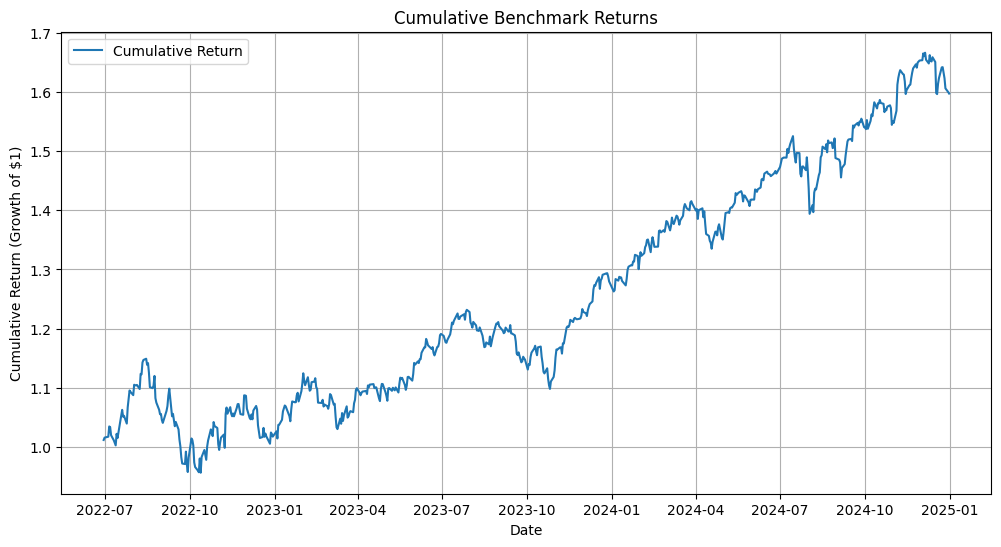

In [7]:
# Calculate cumulative returns
benchmark_returns_1 = benchmark_returns.with_columns(
    (1 + pl.col("benchmark_return")).cum_prod().alias("cumulative_return")
)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(benchmark_returns_1["date"], benchmark_returns_1["cumulative_return"], label="Cumulative Return")
plt.title("Cumulative Benchmark Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_daily_deltas(benchmark_returns: pl.DataFrame, 
                         lookback_months: int = 3, 
                         risk_free_rate: float = 0.0, 
                         frequency: int = 252) -> pl.DataFrame:
    """
    Compute daily market-implied risk aversion (delta) using rolling windows of benchmark returns.

    Args:
        benchmark_returns (pl.DataFrame): columns ['date', 'benchmark_return'] in decimal space.
        lookback_months (int): how many months of data to use for rolling estimation.
        risk_free_rate (float): annualized risk-free rate (decimal).
        frequency (int): trading periods per year (252 for daily).

    Returns:
        pl.DataFrame: ['date', 'delta'] with one delta per date.
    """
    window = lookback_months * 22 
    
    df = (
        benchmark_returns
        .sort("date")
        # Convert back into percent space for calculations
        .with_columns(
            pl.col("benchmark_return").mul(100)
        )
        .with_columns([
            # rolling mean and var over lookback window
            pl.col("benchmark_return").rolling_mean(window_size=window).alias("mean_daily"),
            pl.col("benchmark_return").rolling_var(window_size=window).alias("var_daily")
        ])
        .with_columns([
            # annualize
            (pl.col("mean_daily") * frequency).alias("mean_ann"),
            (pl.col("var_daily") * frequency).alias("var_ann")
        ])
        .with_columns([
            ((pl.col("mean_ann") - risk_free_rate) / pl.col("var_ann")).alias("delta")
        ])
        .select(["date", "delta"])
    )
    return df

In [9]:
deltas = compute_daily_deltas(benchmark_returns, lookback_months=1, risk_free_rate=0.03)

deltas

date,delta
date,f64
2022-06-30,null
2022-07-01,null
2022-07-05,null
2022-07-06,null
2022-07-07,null
…,…
2024-12-24,0.037644
2024-12-26,-0.050169
2024-12-27,-0.124972


In [11]:
def compute_daily_priors(benchmark: pl.DataFrame, 
                         deltas: pl.DataFrame, 
                         cov_matrix_func) -> pl.DataFrame:
    results = []
        
    for date_, subset in benchmark.group_by("date"):
        date_scalar = date_[0]  # unpack the tuple

        barrids = subset["barrid"].to_list()
        weights = subset["weight"].to_numpy()
        delta = deltas.filter(pl.col("date") == date_scalar)["delta"][0]

        if delta is None or np.isnan(delta):
            continue

        cov_mat = cov_matrix_func(date_scalar, barrids)  # <-- pass scalar here
        pi = delta * cov_mat.dot(weights)

        results.append(
            pl.DataFrame({
                "date": [date_scalar] * len(barrids),
                "barrid": barrids,
                "pi": pi
            })
        )
        
    return pl.concat(results)

In [12]:
priors = compute_daily_priors(
    benchmark=benchmark,
    deltas=deltas,
    cov_matrix_func=lambda date_, barrids: sfd.construct_covariance_matrix(date_, barrids).drop("barrid").to_numpy()
)

In [13]:
priors

date,barrid,pi
date,str,f64
2022-10-04,"""USA06Z1""",-0.002492
2022-10-04,"""USA0C11""",-0.002305
2022-10-04,"""USA0H41""",-0.001527
2022-10-04,"""USA0SY1""",-0.001714
2022-10-04,"""USA11I1""",-0.002026
…,…,…
2023-02-09,"""USBOIQ1""",0.008253
2023-02-09,"""USBOLS1""",0.008809
2023-02-09,"""USBONP1""",0.010405


In [14]:
# Step 1: join priors with benchmark weights
priors_with_w = priors.join(
    benchmark.select(["date", "barrid", "weight"]),
    on=["date", "barrid"],
    how="inner"
)

# Step 2: weighted sum of pi for each date
prior_returns = (
    priors_with_w
    .with_columns((pl.col("pi") * pl.col("weight")).alias("weighted_pi"))
    .group_by("date")
    .agg(pl.col("weighted_pi").sum().alias("prior_return"))
)

# Step 3: join with benchmark return
comparison = prior_returns.join(
    benchmark_returns.select(["date", "benchmark_return"]),
    on="date",
    how="inner"
)

# Step 4: compute difference
comparison = comparison.with_columns(
    (pl.col("prior_return") - pl.col("benchmark_return")).alias("diff")
)

comparison


date,prior_return,benchmark_return,diff
date,f64,f64,f64
2022-08-01,0.010523,-0.005115,0.015638
2022-08-02,0.010735,0.016187,-0.005452
2022-08-03,0.010138,-0.000784,0.010923
2022-08-04,0.009874,-0.000131,0.010005
2022-08-05,0.008366,0.000622,0.007745
…,…,…,…
2024-12-24,0.00089,0.000289,0.000602
2024-12-26,-0.001183,-0.011463,0.01028
2024-12-27,-0.002948,-0.010511,0.007563


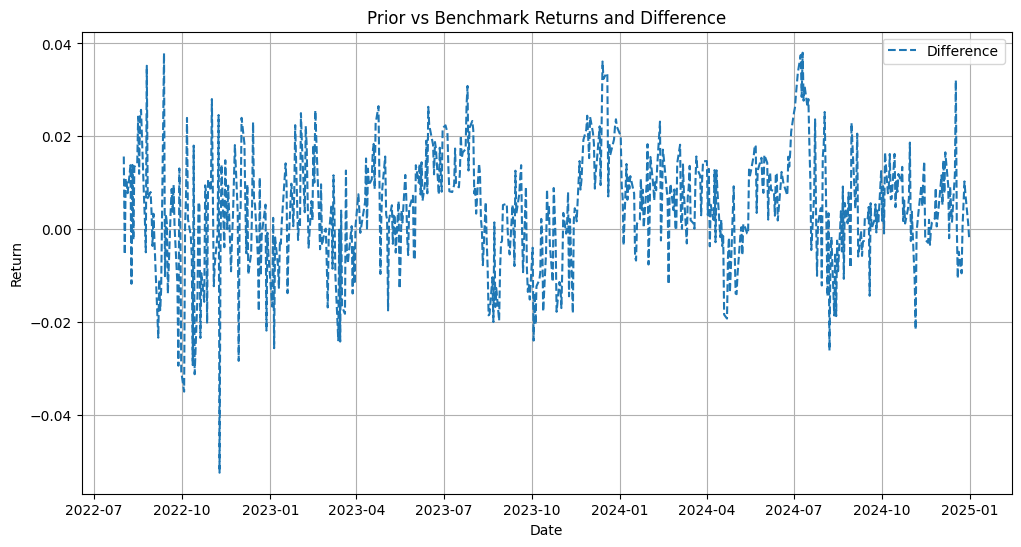

In [15]:
comp_pd = comparison.to_pandas()

# Plot prior_return and benchmark_return
plt.figure(figsize=(12, 6))

# Plot the difference on secondary axis
plt.plot(comp_pd["date"], comp_pd["diff"], label="Difference", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Prior vs Benchmark Returns and Difference")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
average_diff = comp_pd["diff"].mean()

average_diff

np.float64(0.004381032742651403)